<a href="https://colab.research.google.com/github/vivek-a81/EVA6/blob/main/Session6/ExperimentSess6_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

OneCycleLR is removed
Batch size = 64

num_groups=4 by default


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

How to get the model.py file to colab

In [ ]:
# !cp "/content/drive/MyDrive/EVA6/Session 6/model.py" .

In [ ]:
# drive.flush_and_unmount()

In [ ]:
# import sys
# del sys.modules["model"] 
# del model

In [ ]:
import model
import torch
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from tqdm import tqdm
from torchsummary import summary

import matplotlib.pyplot as plt # for ploting the results
import numpy as np # for mathematical work

In [ ]:
# For training set
train = datasets.MNIST('../data', train=True, download=True, #create directory and give the path, True for training set, download if dataset is not available in local storage
                    transform=transforms.Compose([
                        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.40, hue=0.1),
                        transforms.ToTensor(), # Convert image to tensor
                        transforms.Normalize((0.1307,), (0.3081,)),# Normalize image with mean and standard deviation
                        transforms.RandomRotation((-5.0, 5.0), fill=(0.1307,)),
                        ])
                    )


# For testing set
test = datasets.MNIST('../data', train=False,  # create the directory for testing dataset, train is false for testing 
                   transform=transforms.Compose([ 
                        transforms.ToTensor(), # Convert image to tensor
                        transforms.Normalize((0.1307,), (0.3081,)) # Normalize the data
                        ])
                   )

In [ ]:
BATCH_SIZE=64

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available:", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available: True


In [ ]:
figure = plt.figure(figsize=(8,6))
dataiter = iter(train_loader)
images, labels = dataiter.next()
num_of_images = 30
for index in range(1, num_of_images + 1):
    plt.subplot(8, 12, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model_gn = model.Net(norm='gn', drop=0.0).to(device)
summary(model_gn, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
         GroupNorm-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
         GroupNorm-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
        GroupNorm-11            [-1, 8, 12, 12]              16
             ReLU-12            [-1, 8, 12, 12]               0
           Conv2d-13           [-1, 12, 10, 10]             864
        GroupNorm-14           [-1

In [ ]:
model_ln = model.Net(norm='ln').to(device)
summary(model_ln, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
         GroupNorm-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
         GroupNorm-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
        GroupNorm-11            [-1, 8, 12, 12]              16
             ReLU-12            [-1, 8, 12, 12]               0
           Conv2d-13           [-1, 12, 10, 10]             864
        GroupNorm-14           [-1, 12,

In [ ]:
model_bn = model.Net(norm='bn').to(device)
summary(model_bn, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
      BatchNorm2d-11            [-1, 8, 12, 12]              16
             ReLU-12            [-1, 8, 12, 12]               0
           Conv2d-13           [-1, 12, 10, 10]             864
      BatchNorm2d-14           [-1, 12,

# Utility Functions

In [ ]:
def train(model, device, train_loader, optimizer, l1):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  num_loops = 0
  train_loss = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch 
    # accumulates the gradients on subsequent backward passes. Because of this, when you start your training loop, 
    # ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    l1 = 0
    lambda_l1 = 0.01
    if l1:
      for p in model.parameter():
        l1 = l1 + p.abs().sum()
    
    loss = loss + lambda_l1*l1

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update LR
    # if schedular:
    #   scheduler.step()
    
    # Update pbar-tqdm
    train_loss += loss.item()
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    num_loops +=1
    pbar.set_description(desc= f'Batch_id={batch_idx} Loss={train_loss/num_loops:.5f} Accuracy={100*correct/processed:0.2f}')
  
  return 100*correct/processed, train_loss/num_loops


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
    return 100. * correct / len(test_loader.dataset), test_loss

Save the best model

In [ ]:
def save_model(model, epoch, optimizer, name_exp):
  state = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()}
  torch.save(state, name_exp+'.pt')

In [ ]:
def fit(norm, NUM_EPOCHS=20, l1=False, l2=False, drop=0.025, exp_name='experiment'):
  best_accuracy = 0
  training_acc, training_loss, testing_acc, testing_loss = list(), list(), list(), list()
  net =  model.Net(norm=norm, drop=drop).to(device)
  if l2:
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
  else:
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
  # scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.017, epochs=NUM_EPOCHS, steps_per_epoch=len(train_loader))
  schedular = None

  for epoch in range(1,NUM_EPOCHS+1):
      print("EPOCH:", epoch)
      train_acc, train_loss = train(net, device, train_loader, optimizer, l1)
      test_acc, test_loss = test(net, device, test_loader)

      if(test_acc > best_accuracy):
        best_accuracy = test_acc
        #Save this model
        save_model(net, epoch, optimizer, exp_name)

      training_acc.append(train_acc)
      training_loss.append(train_loss)
      testing_acc.append(test_acc)
      testing_loss.append(test_loss)
      
  return net, (training_acc, training_loss, testing_acc, testing_loss)

In [ ]:
def error_rate(model, test_loader):
  model.eval()
  err_count = 0

  for img, target in test_loader:
    img, target = img.to(device), target.to(device)
    output = model(img)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    err_count += pred.not_equal(target.view_as(pred)).sum().item()
  
  return (100. * err_count / len(test_loader.dataset))

#Experiment 1. 
Compare GroupNorm, GroupNorm + L1, GroupNorm + L2 for 15 epochs


In [ ]:
exp_name = 'model_GN'
model_gn, history_gn = fit(norm='gn', NUM_EPOCHS=15, exp_name=exp_name)

#Load the best model for further evalution
model_gn = model.Net(norm='gn').to(device)
model_gn.load_state_dict(torch.load(exp_name+'.pt')['state_dict'])
ep = torch.load(exp_name+'.pt')['epoch']
print('Best Model loss=', history_gn[3][ep-1], "Accuracy= ",  history_gn[2][ep-1])
# model_gn, history_gn = fit(norm='gn', NUM_EPOCHS=15)

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1860, Accuracy: 9417/10000 (94.17%)

EPOCH: 2


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0578, Accuracy: 9827/10000 (98.27%)

EPOCH: 3


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0568, Accuracy: 9819/10000 (98.19%)

EPOCH: 4


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0448, Accuracy: 9867/10000 (98.67%)

EPOCH: 5


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 9886/10000 (98.86%)

EPOCH: 6


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9903/10000 (99.03%)

EPOCH: 7


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9891/10000 (98.91%)

EPOCH: 8


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9889/10000 (98.89%)

EPOCH: 9


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9910/10000 (99.10%)

EPOCH: 10


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 9900/10000 (99.00%)

EPOCH: 11


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9895/10000 (98.95%)

EPOCH: 12


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9908/10000 (99.08%)

EPOCH: 13


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9902/10000 (99.02%)

EPOCH: 14


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9909/10000 (99.09%)

EPOCH: 15


Batch_id=937 Loss=0.04072 Accuracy=98.76: 100%|██████████| 938/938 [00:13<00:00, 70.73it/s]



Test set: Average loss: 0.0284, Accuracy: 9915/10000 (99.15%)

Best Model loss= 0.028361019059177487 Accuracy=  99.15


In [ ]:
exp_name = 'model_GN_L1'
model_gn_l1, history_gn_l1 = fit(norm='gn', NUM_EPOCHS=15, l1=True, exp_name=exp_name)

#Load the best model for further evalution
model_gn_l1 = model.Net(norm='gn').to(device)
model_gn_l1.load_state_dict(torch.load(exp_name+'.pt')['state_dict'])
ep = torch.load(exp_name+'.pt')['epoch']
print('Best Model loss=', history_gn_l1[3][ep-1], "Accuracy= ",  history_gn_l1[2][ep-1])

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1370, Accuracy: 9597/10000 (95.97%)

EPOCH: 2


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0759, Accuracy: 9774/10000 (97.74%)

EPOCH: 3


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0591, Accuracy: 9819/10000 (98.19%)

EPOCH: 4


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0428, Accuracy: 9879/10000 (98.79%)

EPOCH: 5


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0428, Accuracy: 9880/10000 (98.80%)

EPOCH: 6


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9895/10000 (98.95%)

EPOCH: 7


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9905/10000 (99.05%)

EPOCH: 8


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0401, Accuracy: 9887/10000 (98.87%)

EPOCH: 9


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0466, Accuracy: 9865/10000 (98.65%)

EPOCH: 10


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9910/10000 (99.10%)

EPOCH: 11


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9907/10000 (99.07%)

EPOCH: 12


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9915/10000 (99.15%)

EPOCH: 13


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9915/10000 (99.15%)

EPOCH: 14


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9913/10000 (99.13%)

EPOCH: 15


Batch_id=937 Loss=0.04231 Accuracy=98.75: 100%|██████████| 938/938 [00:13<00:00, 70.66it/s]



Test set: Average loss: 0.0333, Accuracy: 9913/10000 (99.13%)

Best Model loss= 0.033722968520969156 Accuracy=  99.15


In [ ]:
exp_name = 'model_GN_L2'
model_gn_l2, history_gn_l2 = fit(norm='gn', NUM_EPOCHS=15, l2=True, exp_name=exp_name)

#Load the best model for further evalution
model_gn_l2 = model.Net(norm='gn').to(device)
model_gn_l2.load_state_dict(torch.load(exp_name+'.pt')['state_dict'])
ep = torch.load(exp_name+'.pt')['epoch']
print('Best Model loss=', history_gn_l2[3][ep-1], "Accuracy= ",  history_gn_l2[2][ep-1])

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1545, Accuracy: 9574/10000 (95.74%)

EPOCH: 2


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0611, Accuracy: 9825/10000 (98.25%)

EPOCH: 3


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0782, Accuracy: 9772/10000 (97.72%)

EPOCH: 4


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0557, Accuracy: 9842/10000 (98.42%)

EPOCH: 5


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0395, Accuracy: 9879/10000 (98.79%)

EPOCH: 6


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9868/10000 (98.68%)

EPOCH: 7


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0452, Accuracy: 9873/10000 (98.73%)

EPOCH: 8


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9894/10000 (98.94%)

EPOCH: 9


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Accuracy: 9890/10000 (98.90%)

EPOCH: 10


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9924/10000 (99.24%)

EPOCH: 11


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9912/10000 (99.12%)

EPOCH: 12


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9910/10000 (99.10%)

EPOCH: 13


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9927/10000 (99.27%)

EPOCH: 14


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9922/10000 (99.22%)

EPOCH: 15


Batch_id=937 Loss=0.04507 Accuracy=98.72: 100%|██████████| 938/938 [00:13<00:00, 70.70it/s]



Test set: Average loss: 0.0349, Accuracy: 9900/10000 (99.00%)

Best Model loss= 0.02950936385989189 Accuracy=  99.27


In [ ]:
exp_name = 'model_GN_L1L2'
model_gn_l1l2, history_gn_l1l2 = fit(norm='gn', NUM_EPOCHS=15, l2=True, l1=True, exp_name=exp_name)

#Load the best model for further evalution
model_gn_l1l2 = model.Net(norm='gn').to(device)
model_gn_l1l2.load_state_dict(torch.load(exp_name+'.pt')['state_dict'])
ep = torch.load(exp_name+'.pt')['epoch']
print('Best Model loss=', history_gn_l1l2[3][ep-1], "Accuracy= ",  history_gn_l1l2[2][ep-1])

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1166, Accuracy: 9679/10000 (96.79%)

EPOCH: 2


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0678, Accuracy: 9800/10000 (98.00%)

EPOCH: 3


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0497, Accuracy: 9838/10000 (98.38%)

EPOCH: 4


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Accuracy: 9869/10000 (98.69%)

EPOCH: 5


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0381, Accuracy: 9886/10000 (98.86%)

EPOCH: 6


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0375, Accuracy: 9888/10000 (98.88%)

EPOCH: 7


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 9888/10000 (98.88%)

EPOCH: 8


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Accuracy: 9885/10000 (98.85%)

EPOCH: 9


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9913/10000 (99.13%)

EPOCH: 10


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9921/10000 (99.21%)

EPOCH: 11


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9901/10000 (99.01%)

EPOCH: 12


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9913/10000 (99.13%)

EPOCH: 13


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9908/10000 (99.08%)

EPOCH: 14


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9924/10000 (99.24%)

EPOCH: 15


Batch_id=937 Loss=0.04573 Accuracy=98.67: 100%|██████████| 938/938 [00:13<00:00, 70.80it/s]



Test set: Average loss: 0.0311, Accuracy: 9912/10000 (99.12%)

Best Model loss= 0.024306061535328626 Accuracy=  99.24


In [ ]:
print('Group Norm \t |\t', error_rate(model_gn, test_loader))
print('Group Norm + L1  |\t', error_rate(model_gn_l1, test_loader))
print('Group Norm + L2  |\t', error_rate(model_gn_l2, test_loader))
print('Group Norm + L1 + L2  |\t', error_rate(model_gn_l1l2, test_loader))

Group Norm 	 |	 0.85
Group Norm + L1  |	 0.85
Group Norm + L2  |	 0.73
Group Norm + L1 + L2  |	 0.76


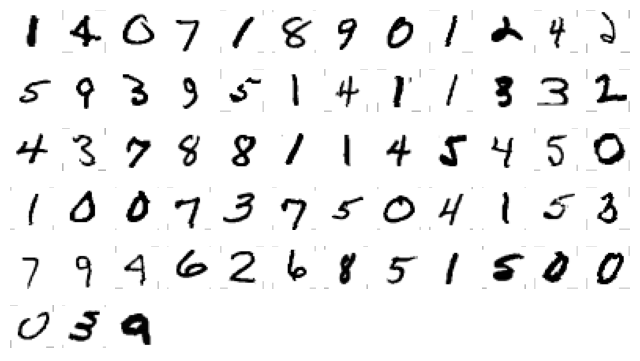

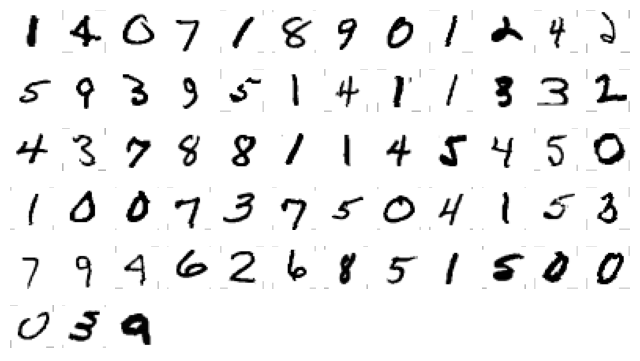

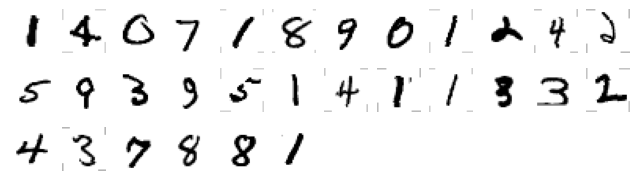

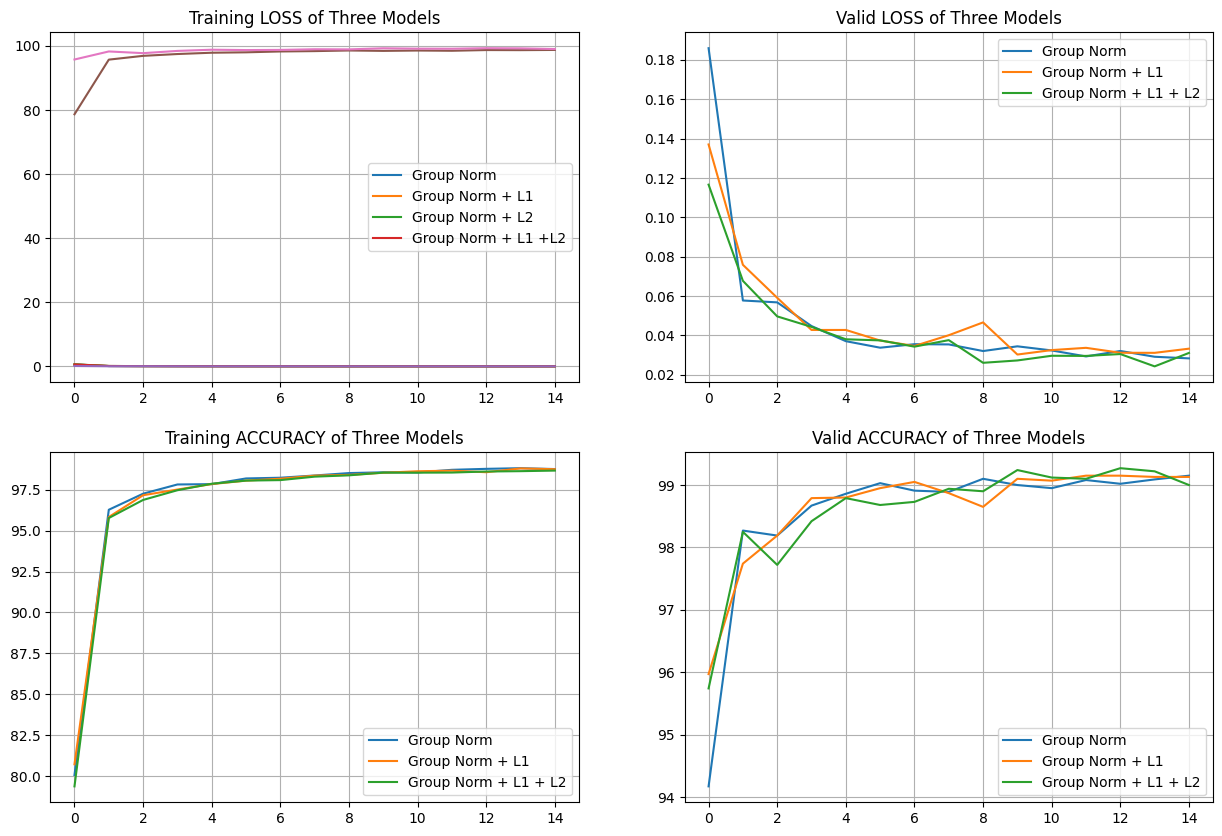

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0,0].set_title('Training LOSS of Three Models')
axs[0,0].plot(history_gn[1], label='Group Norm')
axs[0,0].plot(history_gn_l1[1], label='Group Norm + L1')
axs[0,0].plot(history_gn_l2[1], label='Group Norm + L2')
axs[0,0].plot(history_gn_l1l2[1], label='Group Norm + L1 +L2')
axs[0,0].legend()
axs[0,0].grid()

axs[0,1].set_title('Valid LOSS of Three Models')
axs[0,1].plot(history_gn[3], label='Group Norm')
axs[0,1].plot(history_gn_l1[3], label='Group Norm + L1')
axs[0,0].plot(history_gn_l2[3], label='Group Norm + L2')
axs[0,1].plot(history_gn_l1l2[3], label='Group Norm + L1 + L2')
axs[0,1].legend()
axs[0,1].grid()

axs[1,0].set_title('Training ACCURACY of Three Models')
axs[1,0].plot(history_gn[0], label='Group Norm')
axs[1,0].plot(history_gn_l1[0], label='Group Norm + L1')
axs[0,0].plot(history_gn_l2[0], label='Group Norm + L2')
axs[1,0].plot(history_gn_l1l2[0], label='Group Norm + L1 + L2')
axs[1,0].legend()
axs[1,0].grid()

axs[1,1].set_title('Valid ACCURACY of Three Models')
axs[1,1].plot(history_gn[2], label='Group Norm')
axs[1,1].plot(history_gn_l1[2], label='Group Norm + L1')
axs[0,0].plot(history_gn_l2[2], label='Group Norm + L2')
axs[1,1].plot(history_gn_l2[2], label='Group Norm + L1 + L2')
axs[1,1].legend()
axs[1,1].grid()
plt.show()

#Experiment 2. 
Compare GroupNorm, Batch Norm, Layer Norm for 15 epochs


In [ ]:
# GN results from above Experiment 1

In [ ]:
exp_name = 'model_BN'
model_bn, history_bn = fit(norm='bn', NUM_EPOCHS=15, exp_name=exp_name)

#Load the best model for further evalution
model_bn = model.Net(norm='bn').to(device)
model_bn.load_state_dict(torch.load(exp_name+'.pt')['state_dict'])
ep = torch.load(exp_name+'.pt')['epoch']
print('Best Model loss=', history_bn[3][ep-1], "Accuracy= ",  history_bn[2][ep-1])

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0528, Accuracy: 9833/10000 (98.33%)

EPOCH: 2


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0393, Accuracy: 9867/10000 (98.67%)

EPOCH: 3


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9921/10000 (99.21%)

EPOCH: 4


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9904/10000 (99.04%)

EPOCH: 5


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9913/10000 (99.13%)

EPOCH: 6


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9917/10000 (99.17%)

EPOCH: 7


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9926/10000 (99.26%)

EPOCH: 8


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9931/10000 (99.31%)

EPOCH: 9


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9938/10000 (99.38%)

EPOCH: 10


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9917/10000 (99.17%)

EPOCH: 11


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9929/10000 (99.29%)

EPOCH: 13


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9934/10000 (99.34%)

EPOCH: 14


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9939/10000 (99.39%)

EPOCH: 15


Batch_id=937 Loss=0.03160 Accuracy=99.02: 100%|██████████| 938/938 [00:13<00:00, 71.32it/s]



Test set: Average loss: 0.0205, Accuracy: 9935/10000 (99.35%)

Best Model loss= 0.02149305206881836 Accuracy=  99.39


In [ ]:
exp_name = 'model_LN'
model_ln, history_ln = fit(norm='ln', NUM_EPOCHS=15, exp_name=exp_name)

#Load the best model for further evalution
model_ln = model.Net(norm='ln').to(device)
model_ln.load_state_dict(torch.load(exp_name+'.pt')['state_dict'])
ep = torch.load(exp_name+'.pt')['epoch']
print('Best Model loss=', history_ln[3][ep-1], "Accuracy= ",  history_ln[2][ep-1])

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1063, Accuracy: 9688/10000 (96.88%)

EPOCH: 2


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0874, Accuracy: 9752/10000 (97.52%)

EPOCH: 3


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0625, Accuracy: 9814/10000 (98.14%)

EPOCH: 4


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0434, Accuracy: 9874/10000 (98.74%)

EPOCH: 5


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0507, Accuracy: 9844/10000 (98.44%)

EPOCH: 6


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 9886/10000 (98.86%)

EPOCH: 7


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9876/10000 (98.76%)

EPOCH: 8


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0393, Accuracy: 9879/10000 (98.79%)

EPOCH: 9


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0378, Accuracy: 9884/10000 (98.84%)

EPOCH: 10


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9889/10000 (98.89%)

EPOCH: 11


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Accuracy: 9893/10000 (98.93%)

EPOCH: 12


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Accuracy: 9893/10000 (98.93%)

EPOCH: 13


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9920/10000 (99.20%)

EPOCH: 14


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9913/10000 (99.13%)

EPOCH: 15


Batch_id=937 Loss=0.03445 Accuracy=98.97: 100%|██████████| 938/938 [00:13<00:00, 70.10it/s]



Test set: Average loss: 0.0393, Accuracy: 9887/10000 (98.87%)

Best Model loss= 0.02803615294136107 Accuracy=  99.2


In [ ]:
print('Group Norm \t |\t', error_rate(model_gn, test_loader))
print('Batch Norm \t |\t', error_rate(model_bn, test_loader))
print('Layer Norm \t |\t', error_rate(model_ln, test_loader))

Group Norm 	 |	 0.85
Batch Norm 	 |	 0.61
Layer Norm 	 |	 0.8


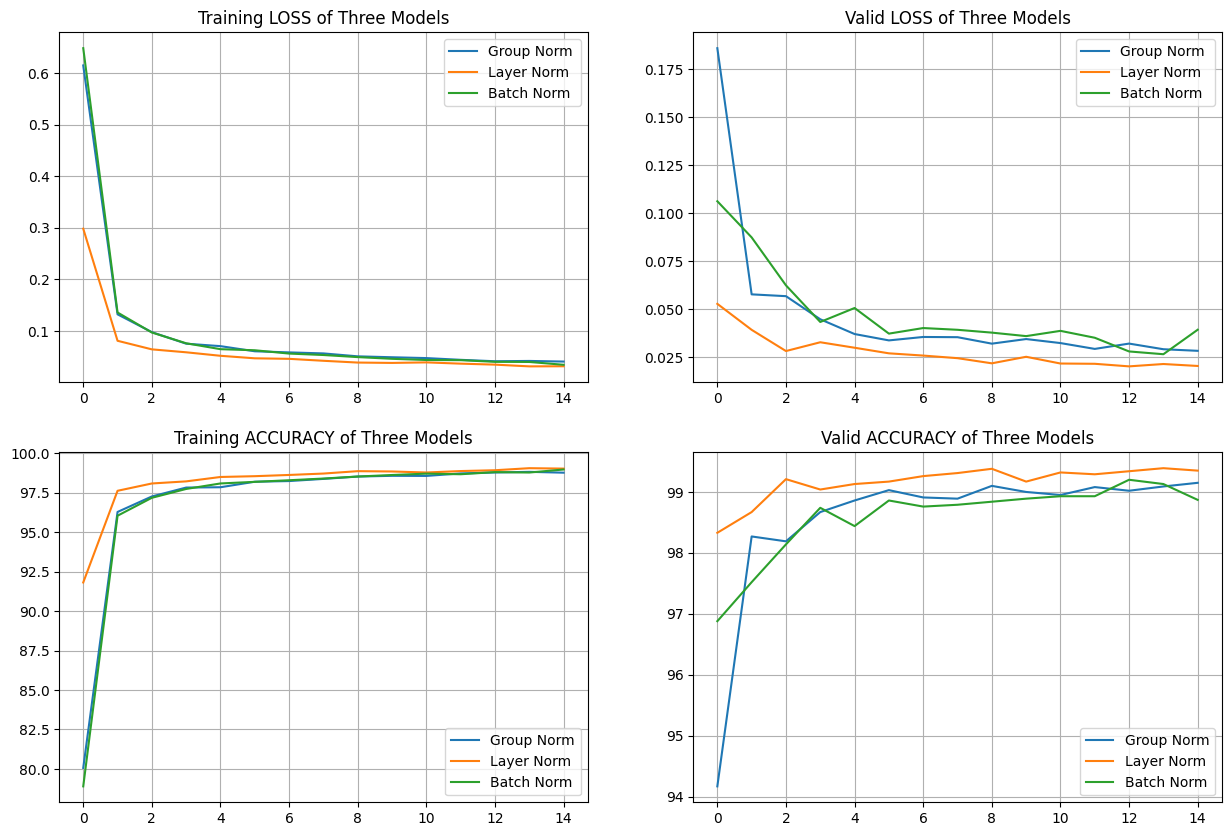

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0,0].set_title('Training LOSS of Three Models')
axs[0,0].plot(history_gn[1], label='Group Norm')
axs[0,0].plot(history_bn[1], label='Layer Norm')
axs[0,0].plot(history_ln[1], label='Batch Norm ')
axs[0,0].legend()
axs[0,0].grid()

axs[0,1].set_title('Valid LOSS of Three Models')
axs[0,1].plot(history_gn[3], label='Group Norm ')
axs[0,1].plot(history_bn[3], label='Layer Norm ')
axs[0,1].plot(history_ln[3], label='Batch Norm ')
axs[0,1].legend()
axs[0,1].grid()

axs[1,0].set_title('Training ACCURACY of Three Models')
axs[1,0].plot(history_gn[0], label='Group Norm')
axs[1,0].plot(history_bn[0], label='Layer Norm ')
axs[1,0].plot(history_ln[0], label='Batch Norm')
axs[1,0].legend()
axs[1,0].grid()

axs[1,1].set_title('Valid ACCURACY of Three Models')
axs[1,1].plot(history_gn[2], label='Group Norm')
axs[1,1].plot(history_bn[2], label='Layer Norm')
axs[1,1].plot(history_ln[2], label='Batch Norm')
axs[1,1].legend()
axs[1,1].grid()
plt.show()

#Experiment 3. 
Compare LayerNorm, LayerNorm + L1, LayerNorm + L2 for 15 epochs

In [ ]:
#LN from experiment 2
# model_ln, history_ln = fit(norm='ln', NUM_EPOCHS=15)

In [ ]:
exp_name = 'model_LN + L1'
model_ln_l1, history_ln_l1 = fit(norm='ln', NUM_EPOCHS=15, l1=True, exp_name=exp_name)

#Load the best model for further evalution
model_ln_l1 = model.Net(norm='ln').to(device)
model_ln_l1.load_state_dict(torch.load(exp_name+'.pt')['state_dict'])
ep = torch.load(exp_name+'.pt')['epoch']
print('Best Model loss=', history_ln_l1[3][ep-1], "Accuracy= ",  history_ln_l1[2][ep-1])

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1026, Accuracy: 9702/10000 (97.02%)

EPOCH: 2


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1049, Accuracy: 9693/10000 (96.93%)

EPOCH: 3


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0497, Accuracy: 9856/10000 (98.56%)

EPOCH: 4


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0401, Accuracy: 9884/10000 (98.84%)

EPOCH: 5


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0503, Accuracy: 9849/10000 (98.49%)

EPOCH: 6


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 9897/10000 (98.97%)

EPOCH: 7


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Accuracy: 9904/10000 (99.04%)

EPOCH: 8


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9914/10000 (99.14%)

EPOCH: 9


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9897/10000 (98.97%)

EPOCH: 10


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9913/10000 (99.13%)

EPOCH: 11


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Accuracy: 9875/10000 (98.75%)

EPOCH: 12


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9913/10000 (99.13%)

EPOCH: 13


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Accuracy: 9888/10000 (98.88%)

EPOCH: 14


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9926/10000 (99.26%)

EPOCH: 15


Batch_id=937 Loss=0.04239 Accuracy=98.75: 100%|██████████| 938/938 [00:13<00:00, 71.18it/s]



Test set: Average loss: 0.0399, Accuracy: 9880/10000 (98.80%)

Best Model loss= 0.027637699122726917 Accuracy=  99.26


In [ ]:
exp_name = 'model_LN + L2'
model_ln_l2, history_ln_l2 = fit(norm='ln', NUM_EPOCHS=15, l2=True, exp_name=exp_name)

#Load the best model for further evalution
model_ln_l2 = model.Net(norm='ln').to(device)
model_ln_l2.load_state_dict(torch.load(exp_name+'.pt')['state_dict'])
ep = torch.load(exp_name+'.pt')['epoch']
print('Best Model loss=', history_ln_l2[3][ep-1], "Accuracy= ",  history_ln_l2[2][ep-1])

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1752, Accuracy: 9489/10000 (94.89%)

EPOCH: 2


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0994, Accuracy: 9714/10000 (97.14%)

EPOCH: 3


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0502, Accuracy: 9843/10000 (98.43%)

EPOCH: 4


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9855/10000 (98.55%)

EPOCH: 5


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Accuracy: 9878/10000 (98.78%)

EPOCH: 6


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Accuracy: 9836/10000 (98.36%)

EPOCH: 7


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9910/10000 (99.10%)

EPOCH: 8


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0366, Accuracy: 9884/10000 (98.84%)

EPOCH: 9


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Accuracy: 9873/10000 (98.73%)

EPOCH: 10


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9917/10000 (99.17%)

EPOCH: 11


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9905/10000 (99.05%)

EPOCH: 12


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9902/10000 (99.02%)

EPOCH: 13


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9909/10000 (99.09%)

EPOCH: 15


Batch_id=937 Loss=0.03889 Accuracy=98.79: 100%|██████████| 938/938 [00:13<00:00, 70.77it/s]



Test set: Average loss: 0.0270, Accuracy: 9920/10000 (99.20%)

Best Model loss= 0.023878011873736976 Accuracy=  99.3


In [ ]:
exp_name = 'model_LN + L2'
model_ln_l1l2, history_ln_l1l2 = fit(norm='ln', NUM_EPOCHS=15, l2=True, exp_name=exp_name)

#Load the best model for further evalution
model_ln_l1l2 = model.Net(norm='ln').to(device)
model_ln_l1l2.load_state_dict(torch.load(exp_name+'.pt')['state_dict'])
ep = torch.load(exp_name+'.pt')['epoch']
print('Best Model loss=', history_ln_l1l2[3][ep-1], "Accuracy= ",  history_ln_l1l2[2][ep-1])

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1414, Accuracy: 9600/10000 (96.00%)

EPOCH: 2


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0676, Accuracy: 9795/10000 (97.95%)

EPOCH: 3


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0694, Accuracy: 9796/10000 (97.96%)

EPOCH: 4


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0635, Accuracy: 9817/10000 (98.17%)

EPOCH: 5


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0540, Accuracy: 9849/10000 (98.49%)

EPOCH: 6


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0440, Accuracy: 9857/10000 (98.57%)

EPOCH: 7


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0425, Accuracy: 9868/10000 (98.68%)

EPOCH: 8


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9895/10000 (98.95%)

EPOCH: 9


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Accuracy: 9882/10000 (98.82%)

EPOCH: 10


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9912/10000 (99.12%)

EPOCH: 11


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9892/10000 (98.92%)

EPOCH: 12


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9893/10000 (98.93%)

EPOCH: 13


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9904/10000 (99.04%)

EPOCH: 14


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9902/10000 (99.02%)

EPOCH: 15


Batch_id=937 Loss=0.04391 Accuracy=98.70: 100%|██████████| 938/938 [00:13<00:00, 70.25it/s]



Test set: Average loss: 0.0369, Accuracy: 9878/10000 (98.78%)

Best Model loss= 0.030543068309687078 Accuracy=  99.12


In [ ]:
print('Layer Norm \t |\t', error_rate(model_ln, test_loader))
print('Layer Norm + L1  |\t', error_rate(model_ln_l1, test_loader))
print('Layer Norm + L2  |\t', error_rate(model_ln_l2, test_loader))
print('Layer Norm + L1 + L2  |\t', error_rate(model_ln_l1l2, test_loader))

Layer Norm 	 |	 0.8
Layer Norm + L1  |	 0.74
Layer Norm + L2  |	 0.7
Layer Norm + L1 + L2  |	 0.88


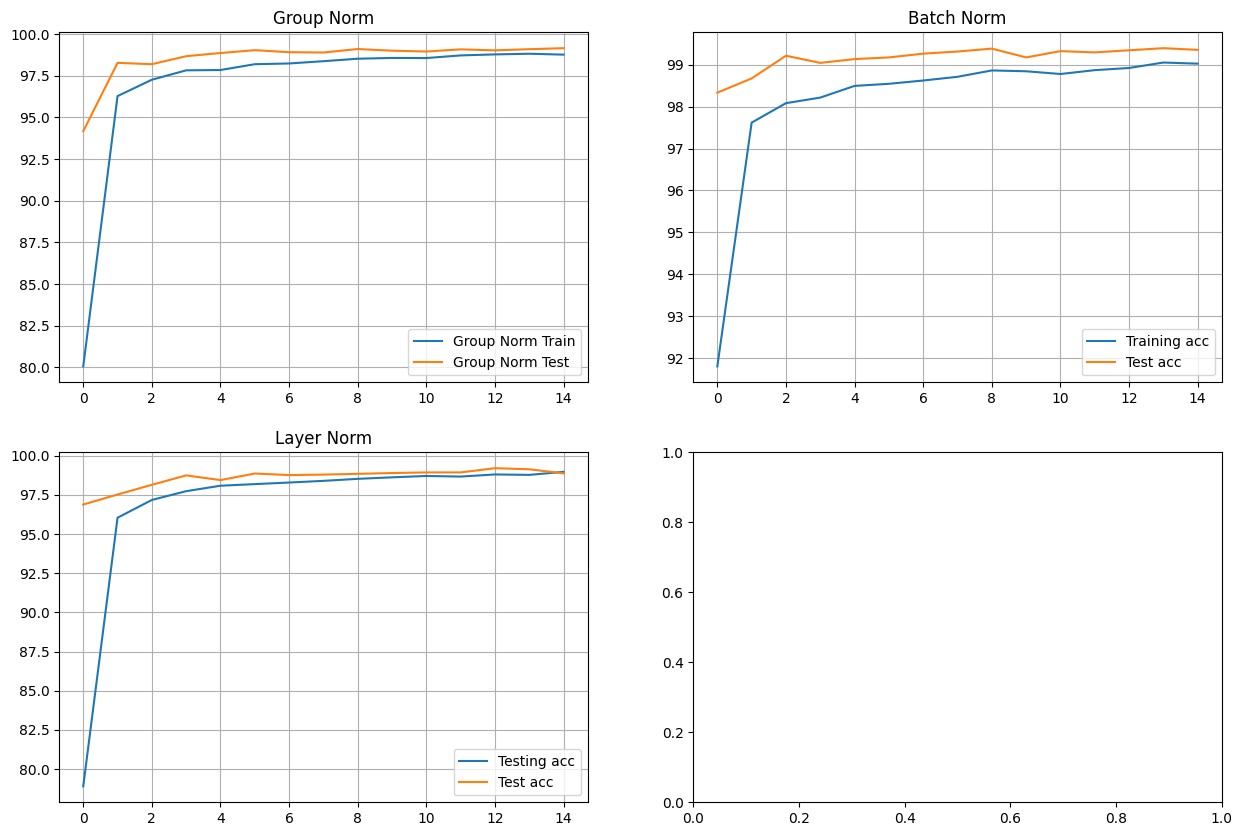

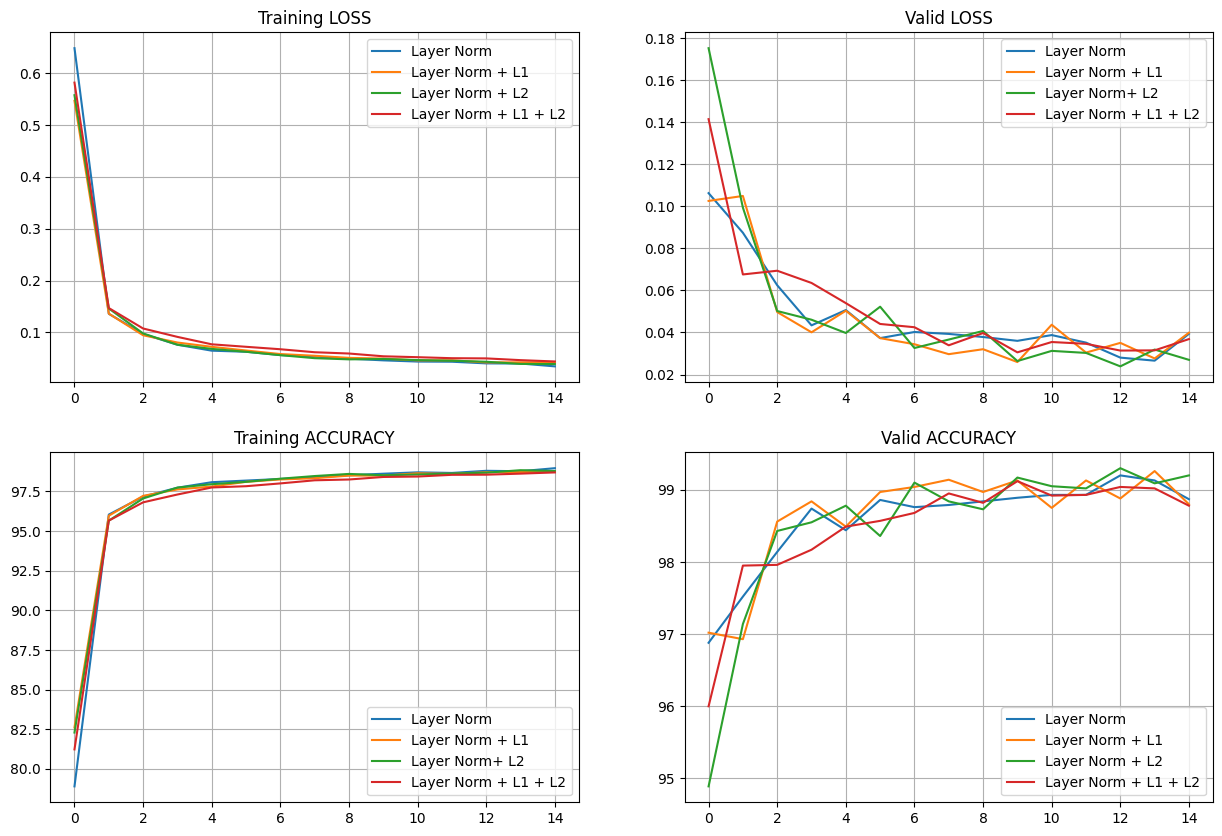

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0,0].set_title('Training LOSS')
axs[0,0].plot(history_ln[1], label='Layer Norm')
axs[0,0].plot(history_ln_l1[1], label='Layer Norm + L1')
axs[0,0].plot(history_ln_l2[1], label='Layer Norm + L2')
axs[0,0].plot(history_ln_l1l2[1], label='Layer Norm + L1 + L2')
axs[0,0].legend()
axs[0,0].grid()

axs[0,1].set_title('Valid LOSS')
axs[0,1].plot(history_ln[3], label='Layer Norm')
axs[0,1].plot(history_ln_l1[3], label='Layer Norm + L1')
axs[0,1].plot(history_ln_l2[3], label='Layer Norm+ L2')
axs[0,1].plot(history_ln_l1l2[3], label='Layer Norm + L1 + L2')
axs[0,1].legend()
axs[0,1].grid()

axs[1,0].set_title('Training ACCURACY')
axs[1,0].plot(history_ln[0], label='Layer Norm')
axs[1,0].plot(history_ln_l1[0], label='Layer Norm + L1')
axs[1,0].plot(history_ln_l2[0], label='Layer Norm+ L2')
axs[1,0].plot(history_ln_l1l2[0], label='Layer Norm + L1 + L2')
axs[1,0].legend()
axs[1,0].grid()

axs[1,1].set_title('Valid ACCURACY')
axs[1,1].plot(history_ln[2], label='Layer Norm')
axs[1,1].plot(history_ln_l1[2], label='Layer Norm + L1')
axs[1,1].plot(history_ln_l2[2], label='Layer Norm + L2')
axs[1,1].plot(history_ln_l1l2[2], label='Layer Norm + L1 + L2')
axs[1,1].legend()
axs[1,1].grid()
plt.show()

# Experiment 4.
Compare WITHOUT DROPOUT GroupNorm, GroupNorm + L1, GroupNorm + L2 for 15 epochs

In [ ]:
exp_name = 'model_GN_noDO'
model_gn_nodo, history_gn_nodo = fit(norm='gn', NUM_EPOCHS=15, drop=0.0, exp_name=exp_name)

#Load the best model for further evalution
model_gn_nodo = model.Net(norm='gn').to(device)
model_gn_nodo.load_state_dict(torch.load(exp_name+'.pt')['state_dict'])
ep = torch.load(exp_name+'.pt')['epoch']
print('Best Model loss=', history_gn_nodo[3][ep-1], "Accuracy= ",  history_gn_nodo[2][ep-1])


  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1282, Accuracy: 9614/10000 (96.14%)

EPOCH: 2


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0717, Accuracy: 9803/10000 (98.03%)

EPOCH: 3


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0783, Accuracy: 9777/10000 (97.77%)

EPOCH: 4


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0401, Accuracy: 9875/10000 (98.75%)

EPOCH: 5


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 9870/10000 (98.70%)

EPOCH: 6


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0408, Accuracy: 9874/10000 (98.74%)

EPOCH: 7


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0409, Accuracy: 9880/10000 (98.80%)

EPOCH: 8


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9901/10000 (99.01%)

EPOCH: 9


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9912/10000 (99.12%)

EPOCH: 10


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9918/10000 (99.18%)

EPOCH: 11


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9887/10000 (98.87%)

EPOCH: 12


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9912/10000 (99.12%)

EPOCH: 13


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9915/10000 (99.15%)

EPOCH: 14


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0393, Accuracy: 9886/10000 (98.86%)

EPOCH: 15


Batch_id=937 Loss=0.02674 Accuracy=99.19: 100%|██████████| 938/938 [00:13<00:00, 69.94it/s]



Test set: Average loss: 0.0304, Accuracy: 9907/10000 (99.07%)

Best Model loss= 0.03159861927554011 Accuracy=  99.18


In [ ]:
exp_name = 'model_GN_L1_noDO'
model_gn_l1_nodo, history_gn_l1_nodo = fit(norm='gn', NUM_EPOCHS=15, drop=0.0, l1=True, exp_name=exp_name)

#Load the best model for further evalution
model_gn_l1_nodo = model.Net(norm='gn').to(device)
model_gn_l1_nodo.load_state_dict(torch.load(exp_name+'.pt')['state_dict'])
ep = torch.load(exp_name+'.pt')['epoch']
print('Best Model loss=', history_gn_l1_nodo[3][ep-1], "Accuracy= ",  history_gn_l1_nodo[2][ep-1])

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0900, Accuracy: 9738/10000 (97.38%)

EPOCH: 2


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0593, Accuracy: 9821/10000 (98.21%)

EPOCH: 3


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0586, Accuracy: 9824/10000 (98.24%)

EPOCH: 4


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9888/10000 (98.88%)

EPOCH: 5


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0401, Accuracy: 9880/10000 (98.80%)

EPOCH: 6


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9896/10000 (98.96%)

EPOCH: 7


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9906/10000 (99.06%)

EPOCH: 8


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9900/10000 (99.00%)

EPOCH: 9


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Accuracy: 9877/10000 (98.77%)

EPOCH: 10


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9908/10000 (99.08%)

EPOCH: 11


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 9899/10000 (98.99%)

EPOCH: 12


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9896/10000 (98.96%)

EPOCH: 13


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9908/10000 (99.08%)

EPOCH: 14


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9911/10000 (99.11%)

EPOCH: 15


Batch_id=937 Loss=0.02661 Accuracy=99.17: 100%|██████████| 938/938 [00:13<00:00, 69.90it/s]



Test set: Average loss: 0.0268, Accuracy: 9905/10000 (99.05%)

Best Model loss= 0.028419937445502728 Accuracy=  99.11


In [ ]:
exp_name = 'model_GN_L2_noDO'
model_gn_l2_nodo, history_gn_l2_nodo = fit(norm='gn', NUM_EPOCHS=15, drop=0.0, l2=True, exp_name=exp_name)

#Load the best model for further evalution
model_gn_l2_nodo = model.Net(norm='gn').to(device)
model_gn_l2_nodo.load_state_dict(torch.load(exp_name+'.pt')['state_dict'])
ep = torch.load(exp_name+'.pt')['epoch']
print('Best Model loss=', history_gn_l2_nodo[3][ep-1], "Accuracy= ",  history_gn_l2_nodo[2][ep-1])

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1169, Accuracy: 9661/10000 (96.61%)

EPOCH: 2


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0555, Accuracy: 9854/10000 (98.54%)

EPOCH: 3


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0591, Accuracy: 9836/10000 (98.36%)

EPOCH: 4


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0387, Accuracy: 9874/10000 (98.74%)

EPOCH: 5


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0387, Accuracy: 9897/10000 (98.97%)

EPOCH: 6


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0455, Accuracy: 9859/10000 (98.59%)

EPOCH: 7


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9899/10000 (98.99%)

EPOCH: 8


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9905/10000 (99.05%)

EPOCH: 9


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9843/10000 (98.43%)

EPOCH: 10


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9919/10000 (99.19%)

EPOCH: 11


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Accuracy: 9877/10000 (98.77%)

EPOCH: 12


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9898/10000 (98.98%)

EPOCH: 13


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9924/10000 (99.24%)

EPOCH: 14


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9916/10000 (99.16%)

EPOCH: 15


Batch_id=937 Loss=0.02753 Accuracy=99.14: 100%|██████████| 938/938 [00:13<00:00, 69.88it/s]



Test set: Average loss: 0.0275, Accuracy: 9908/10000 (99.08%)

Best Model loss= 0.024714831425016747 Accuracy=  99.24


In [ ]:
exp_name = 'model_GN_L1L2_noDO'
model_gn_l1l2_nodo, history_gn_l1l2_nodo = fit(norm='gn', NUM_EPOCHS=15, drop=0.0, l2=True, l1=True, exp_name=exp_name)

#Load the best model for further evalution
model_gn_l1l2_nodo = model.Net(norm='gn').to(device)
model_gn_l1l2_nodo.load_state_dict(torch.load(exp_name+'.pt')['state_dict'])
ep = torch.load(exp_name+'.pt')['epoch']
print('Best Model loss=', history_gn_l1l2_nodo[3][ep-1], "Accuracy= ",  history_gn_l1l2_nodo[2][ep-1])

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1231, Accuracy: 9654/10000 (96.54%)

EPOCH: 2


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0841, Accuracy: 9756/10000 (97.56%)

EPOCH: 3


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Accuracy: 9873/10000 (98.73%)

EPOCH: 4


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0524, Accuracy: 9840/10000 (98.40%)

EPOCH: 5


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 9896/10000 (98.96%)

EPOCH: 6


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9908/10000 (99.08%)

EPOCH: 7


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9892/10000 (98.92%)

EPOCH: 8


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9899/10000 (98.99%)

EPOCH: 9


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0387, Accuracy: 9870/10000 (98.70%)

EPOCH: 10


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9921/10000 (99.21%)

EPOCH: 11


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9918/10000 (99.18%)

EPOCH: 12


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9907/10000 (99.07%)

EPOCH: 13


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9909/10000 (99.09%)

EPOCH: 14


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0408, Accuracy: 9867/10000 (98.67%)

EPOCH: 15


Batch_id=937 Loss=0.02777 Accuracy=99.14: 100%|██████████| 938/938 [00:13<00:00, 70.18it/s]



Test set: Average loss: 0.0302, Accuracy: 9905/10000 (99.05%)

Best Model loss= 0.025752171779982746 Accuracy=  99.21


In [ ]:
print('Group Norm (no DO) \t |\t', error_rate(model_gn_nodo, test_loader))
print('Group Norm (no DO) + L1  |\t', error_rate(model_gn_l1_nodo, test_loader))
print('Group Norm (no DO) + L2  |\t', error_rate(model_gn_l2_nodo, test_loader))
print('Group Norm (no DO) + L1 + L2  |\t', error_rate(model_gn_l1l2_nodo, test_loader))

Group Norm (no DO) 	 |	 0.82
Group Norm (no DO) + L1  |	 0.89
Group Norm (no DO) + L2  |	 0.76
Group Norm (no DO) + L1 + L2  |	 0.79


# Experiment 5
Compare BatchNorm, BatchLayerNorm + L1, BatchLayerNorm + L2 for 15 epochs

In [ ]:
exp_name = 'model_BN + L1'
model_bn_l1, history_bn_l1 = fit(norm='bn', NUM_EPOCHS=15, l1=True, exp_name=exp_name)

#Load the best model for further evalution
model_bn_l1 = model.Net(norm='bn').to(device)
model_bn_l1.load_state_dict(torch.load(exp_name+'.pt')['state_dict'])
ep = torch.load(exp_name+'.pt')['epoch']
print('Best Model loss=', history_bn_l1[3][ep-1], "Accuracy= ",  history_bn_l1[2][ep-1])

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0551, Accuracy: 9830/10000 (98.30%)

EPOCH: 2


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0403, Accuracy: 9868/10000 (98.68%)

EPOCH: 3


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9910/10000 (99.10%)

EPOCH: 4


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9912/10000 (99.12%)

EPOCH: 5


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9899/10000 (98.99%)

EPOCH: 6


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9918/10000 (99.18%)

EPOCH: 7


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9934/10000 (99.34%)

EPOCH: 8


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9923/10000 (99.23%)

EPOCH: 9


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9934/10000 (99.34%)

EPOCH: 10


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9942/10000 (99.42%)

EPOCH: 12


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9923/10000 (99.23%)

EPOCH: 13


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9935/10000 (99.35%)

EPOCH: 14


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9929/10000 (99.29%)

EPOCH: 15


Batch_id=937 Loss=0.03266 Accuracy=98.96: 100%|██████████| 938/938 [00:13<00:00, 69.88it/s]



Test set: Average loss: 0.0227, Accuracy: 9924/10000 (99.24%)



RuntimeError: ignored

In [ ]:
exp_name = 'model_BN + L1'
#Load the best model for further evalution
model_bn_l1 = model.Net(norm='bn').to(device)
model_bn_l1.load_state_dict(torch.load(exp_name+'.pt')['state_dict'])
ep = torch.load(exp_name+'.pt')['epoch']
print('Best Model loss=', history_bn_l1[3][ep-1], "Accuracy= ",  history_bn_l1[2][ep-1])

Best Model loss= 0.01843078408781439 Accuracy=  99.42


In [ ]:
exp_name = 'model_BN + L2'
model_bn_l2, history_bn_l2 = fit(norm='bn', NUM_EPOCHS=15, l2=True, exp_name=exp_name)

#Load the best model for further evalution
model_bn_l2 = model.Net(norm='bn').to(device)
model_bn_l2.load_state_dict(torch.load(exp_name+'.pt')['state_dict'])
ep = torch.load(exp_name+'.pt')['epoch']
print('Best Model loss=', history_bn_l2[3][ep-1], "Accuracy= ",  history_bn_l2[2][ep-1])

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0634, Accuracy: 9807/10000 (98.07%)

EPOCH: 2


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9870/10000 (98.70%)

EPOCH: 3


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0438, Accuracy: 9860/10000 (98.60%)

EPOCH: 4


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9909/10000 (99.09%)

EPOCH: 5


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9904/10000 (99.04%)

EPOCH: 6


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9912/10000 (99.12%)

EPOCH: 7


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9912/10000 (99.12%)

EPOCH: 8


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9913/10000 (99.13%)

EPOCH: 9


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9906/10000 (99.06%)

EPOCH: 10


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9929/10000 (99.29%)

EPOCH: 11


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9925/10000 (99.25%)

EPOCH: 12


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9906/10000 (99.06%)

EPOCH: 13


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9927/10000 (99.27%)

EPOCH: 14


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9915/10000 (99.15%)

EPOCH: 15


Batch_id=937 Loss=0.03402 Accuracy=99.00: 100%|██████████| 938/938 [00:13<00:00, 70.23it/s]



Test set: Average loss: 0.0212, Accuracy: 9931/10000 (99.31%)

Best Model loss= 0.021199318785965444 Accuracy=  99.31


In [ ]:
exp_name = 'model_BN + L1+ L2'
model_bn_l1l2, history_bn_l1l2 = fit(norm='bn', NUM_EPOCHS=15, l2=True, exp_name=exp_name)

#Load the best model for further evalution
model_bn_l1l2 = model.Net(norm='bn').to(device)
model_bn_l1l2.load_state_dict(torch.load(exp_name+'.pt')['state_dict'])
ep = torch.load(exp_name+'.pt')['epoch']
print('Best Model loss=', history_ln_l1l2[3][ep-1], "Accuracy= ",  history_ln_l1l2[2][ep-1])

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0563, Accuracy: 9835/10000 (98.35%)

EPOCH: 2


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 9890/10000 (98.90%)

EPOCH: 3


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9902/10000 (99.02%)

EPOCH: 4


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9910/10000 (99.10%)

EPOCH: 5


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9931/10000 (99.31%)

EPOCH: 6


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9905/10000 (99.05%)

EPOCH: 7


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9930/10000 (99.30%)

EPOCH: 8


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9914/10000 (99.14%)

EPOCH: 9


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9930/10000 (99.30%)

EPOCH: 10


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9933/10000 (99.33%)

EPOCH: 11


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9942/10000 (99.42%)

EPOCH: 12


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9943/10000 (99.43%)

EPOCH: 13


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9934/10000 (99.34%)

EPOCH: 14


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9929/10000 (99.29%)

EPOCH: 15


Batch_id=937 Loss=0.03444 Accuracy=98.94: 100%|██████████| 938/938 [00:13<00:00, 70.24it/s]



Test set: Average loss: 0.0194, Accuracy: 9936/10000 (99.36%)

Best Model loss= 0.034606691037118435 Accuracy=  98.93


In [ ]:
print('Best Model loss=', history_bn_l1l2[3][ep-1], "Accuracy= ",  history_bn_l1l2[2][ep-1])

Best Model loss= 0.01828058368070051 Accuracy=  99.43


In [ ]:
print('Batch Norm \t |\t', error_rate(model_bn, test_loader))
print('Batch Norm + L1  |\t', error_rate(model_bn_l1, test_loader))
print('Batch Norm + L2  |\t', error_rate(model_bn_l2, test_loader))
print('Batch Norm + L1 + L2  |\t', error_rate(model_bn_l1l2, test_loader))

Batch Norm 	 |	 0.61
Batch Norm + L1  |	 0.58
Batch Norm + L2  |	 0.69
Batch Norm + L1 + L2  |	 0.57


# Misclassification plot

In [ ]:
def plot_misclassified(model, test_loader, norm_name):
  count = 0
  k = 0
  misclf = list()
  while count<=20:
    img, label = test_loader.dataset[k]
    pred = model(img.unsqueeze(0).to(device)) # Prediction
    pred = pred.argmax().item()

    k += 1
    if pred!=label:
      misclf.append((img, label, pred))
      count += 1
  
  rows, cols = 5,4
  figure = plt.figure(figsize=(10,14))

  for i in range(1, cols * rows + 1):
    img, label, pred = misclf[i-1]

    figure.add_subplot(rows, cols, i) # adding sub plot
    plt.suptitle(norm_name, fontsize=10)
    plt.title(f"Predcited label {pred}\n True Label: {label}") # title of plot
    plt.axis("off") # hiding the axis
    plt.imshow(img.squeeze(), cmap="gray") # showing the plot

  plt.show()

In [ ]:
plot_misclassified(model_gn, test_loader, 'Group Normalization + L1')

In [ ]:
plot_misclassified(model_ln, test_loader, 'Layer Normalization + L2')

In [ ]:
plot_misclassified(model_bn, test_loader, 'Batch Normalization + L1 + L2')

In [ ]:
print('Layer Norm \t |\t', error_rate(model_ln, test_loader))
print('Layer Norm + L1  |\t', error_rate(model_ln_l1, test_loader))
print('Layer Norm + L2  |\t', error_rate(model_ln_l2, test_loader))
print('Layer Norm + L1 + L2  |\t', error_rate(model_ln_l1l2, test_loader))